In [2]:
from warnings import filterwarnings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [26]:
import nltk

# Stopwords için
nltk.download('stopwords')

# TextBlob tokenization için
nltk.download('punkt')

# Lemmatization için
nltk.download('wordnet')

# Eğer pos tag kullanacaksan
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [27]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [28]:
# Text Preprocessing
df = pd.read_csv("amazon_reviews.csv", sep=",")
print(df.head())


       reviewerID        asin  reviewerName helpful                                         reviewText  overall                                 summary  unixReviewTime  reviewTime  day_diff  \
0  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]                                         No issues.     4.00                              Four Stars      1406073600  2014-07-23       138   
1  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]  Purchased this for my device, it worked as adv...     5.00                           MOAR SPACE!!!      1382659200  2013-10-25       409   
2  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]  it works as expected. I should have sprung for...     4.00               nothing to really say....      1356220800  2012-12-23       715   
3   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]  This think has worked out great.Had a diff. br...     5.00  Great buy at this price!!!  *** UPDATE      1384992000  2013-11-21       382   
4  A375ZM4U047O79  B007WTAJTO  2&am

In [38]:
# Küçük harfe dönüştür
df['reviewText'] = df['reviewText'].str.lower()

# Noktalama işaretlerini kaldır
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '', regex=True)

# Sayıları kaldır
df['reviewText'] = df['reviewText'].str.replace('\d', '', regex=True)

# Stopwords kaldır
from nltk.corpus import stopwords
sw = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(w for w in str(x).split() if w not in sw))

# Rare words kaldır
temp_df = pd.Series(' '.join(df['reviewText'].astype(str)).split()).value_counts()
drops = temp_df[temp_df <= 1]
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(w for w in x.split() if w not in drops))

# Lemmatization
from textblob import Word
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(w).lemmatize() for w in x.split()]))

# En son güncel df'i göster
df['reviewText']


0                                                   issue
1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used capability samsung galaxy note greatly ex...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewText, Length: 4915, dtype: object

In [40]:
# 2. Text Visualization
# Terim Frekanslarının Hesaplanması

tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.sort_values("tf", ascending=False)


,words,tf
27,card,5537.00
14,work,2044.00
7,phone,1909.00
28,gb,1756.00
91,great,1445.00
...,...,...
3631,revise,2.00
3630,million,2.00
3628,hooked,2.00
3627,mbit,2.00


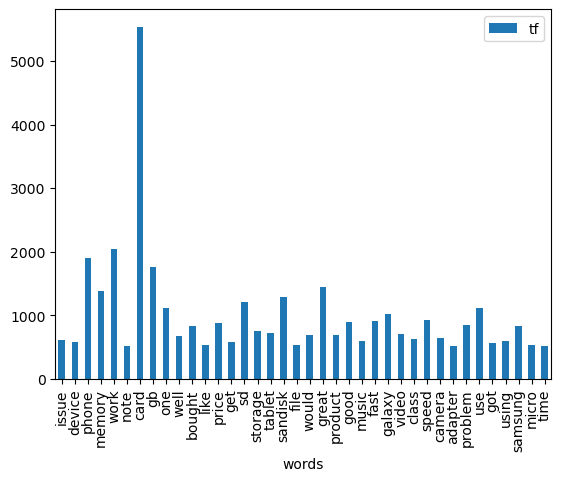

In [41]:
# Barplot
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

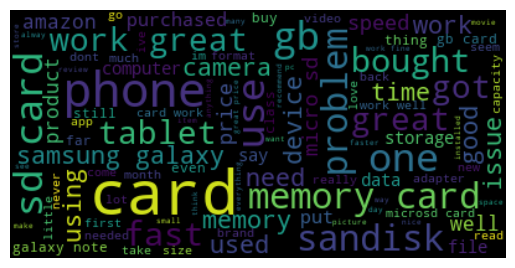

In [45]:
# Wordcloud
text = " ".join(i for i in df.reviewText)

wordcloud = WordCloud(max_font_size=50,
                      max_words=100).generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

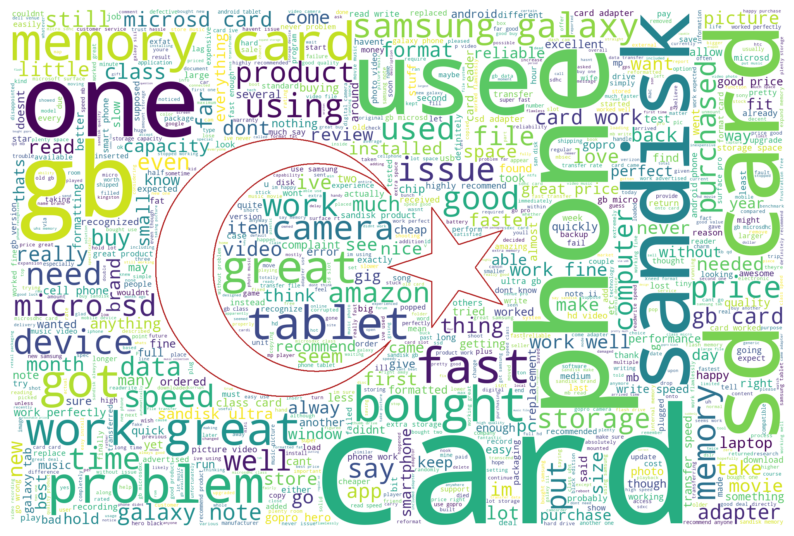

In [48]:
# Şablonlara Göre Wordcloud
tr_mask = np.array(Image.open("tr.png"))

wc = WordCloud(background_color="white",
               max_words=1000,
               mask=tr_mask,
               contour_width=3,
               contour_color="firebrick")

wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
wc.to_file("kelime_bulutu.png") #png şeklinde kayıt olunur.

In [49]:
# 3. Sentiment Analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


True

In [52]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The film was awesome")


sia.polarity_scores("I liked this music but it is not good as the other one")


df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["polarity_score"]

0      0.00
1      0.00
2      0.40
3      0.65
4      0.86
       ... 
4910   0.08
4911   0.18
4912   0.85
4913   0.69
4914   0.53
Name: polarity_score, Length: 4915, dtype: float64

In [55]:
#1-unsupervised yöntemi ile bunun üzerinden supervised learninge gidebilirim 
#2-bir metinden duygu durumunnun pozitif mi negatif mi olduğunu gösteren sınıflandrıma modeli geliştirme

df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
#o dan büyük olanlara positif o dan küçüklere negatif sayı denir
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentiment_label"].value_counts()
df.groupby("sentiment_label")["overall"].mean()

df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

y = df["sentiment_label"]
X = df["reviewText"]

In [ ]:
import textblob.download_corpora
textblob.download_corpora.download_all()

In [65]:
# Count Vectors
# words
# kelimelerin nümerik temsilleri

# characters
# karakterlerin numerik temsilleri

# ngram
from textblob import TextBlob

a = """Bu örneği anlaşılabilmesi için daha uzun bir metin üzerinden göstereceğim.
N-gram'lar birlikte kullanılan kelimelerin kombinasyolarını gösterir ve feature üretmek için kullanılır"""


for gram in TextBlob(a).ngrams(3):
    print(gram)


['Bu', 'örneği', 'anlaşılabilmesi']
['örneği', 'anlaşılabilmesi', 'için']
['anlaşılabilmesi', 'için', 'daha']
['için', 'daha', 'uzun']
['daha', 'uzun', 'bir']
['uzun', 'bir', 'metin']
['bir', 'metin', 'üzerinden']
['metin', 'üzerinden', 'göstereceğim']
['üzerinden', 'göstereceğim', "N-gram'lar"]
['göstereceğim', "N-gram'lar", 'birlikte']
["N-gram'lar", 'birlikte', 'kullanılan']
['birlikte', 'kullanılan', 'kelimelerin']
['kullanılan', 'kelimelerin', 'kombinasyolarını']
['kelimelerin', 'kombinasyolarını', 'gösterir']
['kombinasyolarını', 'gösterir', 've']
['gösterir', 've', 'feature']
['ve', 'feature', 'üretmek']
['feature', 'üretmek', 'için']
['üretmek', 'için', 'kullanılır']


In [75]:
from sklearn.feature_extraction.text import CountVectorizer

In [76]:
# word frekans
corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

vectorizer = CountVectorizer()
X_c = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

Kelime Sözlüğü → corpus’taki tüm kelimelerin listesi (alfabetik sıralı).

Tablodaki sayılar → o satırdaki cümlede kelimenin kaç kez geçtiğini gösteriyor.

In [74]:
X_c.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [78]:
# n-gram frekans
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))# 2li 2'li gruplar türettik
X_n = vectorizer2.fit_transform(corpus)
vectorizer2.get_feature_names_out()
X_n.toarray()


array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]])

In [80]:
#kendii verimde uygulama 
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

vectorizer.get_feature_names_out()[10:15]
X_count.toarray()[10:15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])